# How to use JAX to do optimal control with the Fossen model

JAX is basically a wrapper around numpy, but on steroids — it enables automatic gradient computation and JIT compilation.

In [4]:
import jax.numpy as np
from jax import jacfwd, grad, jit
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
import sys; sys.path.append('../src/')
from fossen import Fossen

Let's instantiate the Fossen dynamics model with the default parameters. Here, we print the parameters so you can see what they are.

In [5]:
model = Fossen()
print(model.params)

OrderedDict([('Nrr', 150.0), ('Izz', 10.0), ('Kt1', 0.1), ('zb', 0.0), ('Mqq', 100.0), ('ycp', 0.0), ('xb', 0.0), ('zcp', 0.0), ('Yvv', 100.0), ('yg', 0.0), ('Ixx', 10.0), ('Kt0', 0.1), ('Xuu', 1.0), ('xg', 0.0), ('Zww', 100.0), ('W', 151.074), ('m', 15.4), ('B', 151.074), ('zg', 0.0), ('Kpp', 100.0), ('Qt1', -0.001), ('Qt0', 0.001), ('Iyy', 10.0), ('yb', 0.0), ('xcp', 0.1)])


Alrighty, the two key things that need to be defined in a `Dynamics` model are the `state_dynamics` and `lagrangian` — everything else (e.g. the Hamiltonian) can be automatically computed and compiled via JAX. Wow! First, to get things started, let's define an arbitrary state
`x, y, z, et0, eps1, eps2, eps3, u, v, w, p, q, r = state` and control `rpm0, rpm1, de, dr = control`, and compute the first-order state dynamics $\dot x = f(x, u)$.

Note that we need to explicitly supply the system parameters (shown above) as an ordered list (which they already are in `model.params.values()`) to the functions (`state_dynamics`, `lagrangian`, etc.), because they need to be considered state functions by JAX in order to be compiled. 

In [6]:
state = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=np.float32)
control = np.array([1000, 1000, 0.1, 0.1])
print(model.state_dynamics(state, control, *model.params.values()))

[ 0.         0.         0.        -0.         0.         0.
  0.        12.857576  -1.2965379  1.2900605  0.         0.
  0.       ]


Alright, cool! What about the Lagrangian. Let's see. Note, in the current formalism accepts an array of homotopy parameters — allowing you to perform homotopy contuniation for trajectory optimisaton (cf. https://arxiv.org/abs/1902.10139). For the Fossen model, we've defined a double homotopy, between (quadratic-effort)-time.

In [7]:
print('Quadratic cost {}'.format(model.lagrangian(state, control, [0,0], *model.params.values())))
print('Effort cost {}'.format(model.lagrangian(state, control, [1,0], *model.params.values())))

# if the second homotopy parameter is 1 (time cost), then the Lagrangian is invariant to the first homotopy parameter
print('Time cost {}'.format(model.lagrangian(state, control, [0,1], *model.params.values())))
print('Time cost {}'.format(model.lagrangian(state, control, [1,1], *model.params.values())))

Quadratic cost 0.6920414566993713
Effort cost 1.1764705181121826
Time cost 2.0
Time cost 2.0


# LQR
Anyway, now that we're somewhat familar, let's see if we can use JAX to get the formulation of an LQR controller.

$$
\dot x = g(x, u) = \frac{\partial f}{\partial x} \cdot x + \frac{\partial f}{\partial u} \cdot u
= A \cdot x + B \cdot u
$$

In [8]:
A = jit(jacfwd(model.state_dynamics, argnums=0))
a = A(state, control, *model.params.values())
a

DeviceArray([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,
               0. ,  0. ,  0. ],
             [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,
               0. ,  0. ,  0. ],
             [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,
               0. ,  0. ,  0. ],
             [-0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,
              -0. , -0. , -0. ],
             [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
               0.5,  0. ,  0. ],
             [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
               0. ,  0.5,  0. ],
             [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
               0. ,  0. ,  0.5],
             [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
               0. ,  0. ,  0. ],
             [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
               0. ,  0. ,  0. ],
             [ 0. ,  0. ,  0. ,  0. ,

In [9]:
B = jit(jacfwd(model.state_dynamics, argnums=1))
b = B(state, control, *model.params.values())
b

DeviceArray([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
               0.00000000e+00],
             [ 6.42878795e-03,  6.42878795e-03, -1.29006064e+00,
              -1.29006064e+00],
             [-6.48268964e-04, -6.48268964e-04,  0.00000000e+00,
              -1.29221325e+01],
             [ 6.45030348e-04,  6.45030348e-04,  1.28575764e+01,
              -1.29437819e-01],
             [ 9.90033368e-05,

In [10]:
# checks out!
print(a.shape, b.shape)

(13, 13) (13, 4)


Alright, let's make the full form of $g(x, u)$.

In [11]:
@jit
def g(state, control, *params):

    # Jacobian of f(x, u) wrt x (A) and u (B)
    A = jacfwd(model.state_dynamics, argnums=0)(state, control, *params)
    B = jacfwd(model.state_dynamics, argnums=1)(state, control, *params)

    # compute the linear dynamics dx/dt = Ax + Bu
    return np.dot(A, state) + np.dot(B, control)

print(g(state, control, *model.params.values()))

[ 0.         0.         0.         0.         0.         0.
  0.        12.599564  -2.5887513  2.5628746  0.         0.
  0.       ]


Let's clarify some things:

- `@jit` is the JAX decorator that compiled your function to super fast code
- `*` is a list unpacker, which is built into Python.
- `argnums` determines which function argument `jacfwd` computes the Jacobian wrt.

Now, let's compare the full nonlinear dynamics to the lineared one we just constructed.

In [12]:
print('Nonlinear\n {}'.format(model.state_dynamics(state, control, *model.params.values())))
print('Linearised\n {}'.format(g(state, control, *model.params.values())))

Nonlinear
 [ 0.         0.         0.        -0.         0.         0.
  0.        12.857576  -1.2965379  1.2900605  0.         0.
  0.       ]
Linearised
 [ 0.         0.         0.         0.         0.         0.
  0.        12.599564  -2.5887513  2.5628746  0.         0.
  0.       ]


Now, let's numerically integrate both dynamics functions and comapare them.

In [13]:
t0, tf = 0.0, 20.0

# integrate nonlinear dynamics
solf = solve_ivp(
    jit(lambda t, x: model.state_dynamics(x, control, *model.params.values())),
    (t0, tf),
    state,
    method='DOP853',
    rtol=1e-8,
    atol=1e-8
)

# integrate linearised dynamics
solg = solve_ivp(
    jit(lambda t, x: g(x, control, *model.params.values())),
    (t0, tf),
    state,
    method='DOP853',
    rtol=1e-8,
    atol=1e-8
)

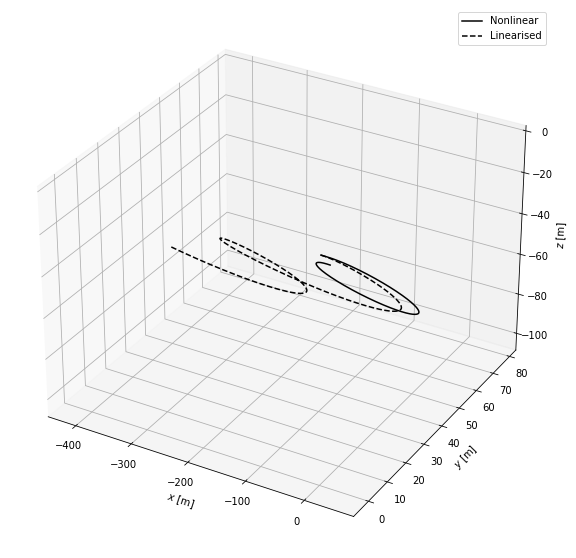

In [14]:
# plot them!
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(solf.y[0,:], solf.y[1,:], solf.y[2,:], 'k-', label='Nonlinear')
ax.plot(solg.y[0,:], solg.y[1,:], solg.y[2,:], 'k--', label='Linearised')

# labels
ax.set_xlabel('$x$ [m]')
ax.set_ylabel('$y$ [m]')
ax.set_zlabel('$z$ [m]')

ax.legend()

plt.show()

Can we also compute the LQR cost?